# Port ECGSYNTH to python

From these two scripts: 

- https://physionet.org/content/ecgsyn/1.0.0/Matlab/ecgsyn.m 
- https://physionet.org/content/ecgsyn/1.0.0/Matlab/derivsecgsyn.m

In [13]:
import pandas as pd
import numpy as np
import neurokit2 as nk
import scipy
import math

%matplotlib inline

In [18]:
def _ecg_simulate_ecgsynth(sfecg=256, N=256, Anoise=0, hrmean=60, hrstd=1, lfhfratio=0.5, sfint=256, ti=[-70, -15, 0, 15, 100], ai=[1.2, -5, 30, -7.5, 0.75], bi=[0.25, 0.1, 0.1, 0.1, 0.4]):
    """
    Credits
    -------
    This function is a python translation of the matlab script by Patrick McSharry & Gari Clifford (2013). All credits go to them.
    """
# Set parameter default values
#    sfecg = 256;
#    N = 256;
#    Anoise = 0;
#    hrmean = 60;
#    hrstd = 1;
#    lfhfratio = 0.5;
#    sfint = 512;
#    ti = [-70, -15, 0, 15, 100];
#    ai=[1.2 -5 30 -7.5 0.75];
#    bi=[0.25 0.1 0.1 0.1 0.4];


    ti = np.array(ti)*np.pi/180

    # Adjust extrema parameters for mean heart rate
    hrfact =  np.sqrt(hrmean/60)
    hrfact2 = np.sqrt(hrfact)
    bi = hrfact*np.array(bi)
    ti = np.array([hrfact2, hrfact, 1, hrfact, hrfact2])*ti

    # Check that sfint is an integer multiple of sfecg
    q = np.round(sfint/sfecg)
    qd = sfint/sfecg
    if q != qd:
        raise ValueError('Internal sampling frequency (sfint) must be an integer multiple of the ECG sampling frequency (sfecg). Your current choices are: sfecg = ' + str(sfecg) + ' and sfint = ' + str(sfint) + '.')

    # Define frequency parameters for rr process
    # flo and fhi correspond to the Mayer waves and respiratory rate respectively
    flo = 0.1
    fhi = 0.25
    flostd = 0.01
    fhistd = 0.01
    fid = 1


    # Calculate time scales for rr and total output
    sfrr = 1
    trr = 1/sfrr
    tstep = 1/sfecg
    rrmean = 60/hrmean
    n = (np.ceil(np.log2(N*rrmean/trr)))**2

    rr0 = _ecg_simulate_rrprocess(flo,fhi,flostd,fhistd,lfhfratio,hrmean,hrstd,sfrr,n)

    # Upsample rr time series from 1 Hz to sfint Hz
    rr = nk.signal_resample(rr0, sampling_rate=1, desired_sampling_rate=sfint)

    # Make the rrn time series
    dt = 1/sfint
    rrn = np.zeros(len(rr))
    tecg=0
    i = 0
    while i < len(rr):
       tecg = tecg+rr[i]
       ip = int(np.round(tecg/dt))
       rrn[i:ip] = rr[i]
       i = ip+1
    Nt = ip

    # Integrate system using fourth order Runge-Kutta
    x0 = [1, 0, 0.04]

    # ------- THIS IS WHERE THINGS START TO GET COMPLICATED
#    Tspan = np.arange(0, (Nt-1)*dt, dt)
    Tspan = np.linspace(0, (Nt-1)*dt, len(rrn))
#    T, X0 = _ecg_simulate_derivsecgsyn(t=Tspan, rr=rrn, ti=ti, x=x0, flag=[], sfint, ti, ai, bi)
    dxdt = _ecg_simulate_derivsecgsyn(Tspan=Tspan, rrn=rrn, ti=ti, x0=x0, sfint=sfint, ai=ai, bi=bi)

    # downsample to required sfecg
    X = dxdt[np.arange(0,len(dxdt),q).astype(int)]

    # Scale signal to lie between -0.4 and 1.2 mV
    z = X.copy()
    zmin = np.min(z)
    zmax = np.max(z)
    zrange = zmax - zmin
    z = (z - zmin)*(1.6)/zrange -0.4

    # include additive uniformly distributed measurement noise
    eta = 2*np.random.uniform(len(z))-1
    s = z + Anoise*eta

    return(s)







def _ecg_simulate_derivsecgsyn(Tspan, rrn, ti, x0=[1, 0, 0.04], sfint=512, ai=[1.2, -5, 30, -7.5, 0.75], bi=[0.25, 0.1 , 0.1 , 0.1 , 0.4 ]):

    xi = np.cos(ti)
    yi = np.sin(ti)
    ta = math.atan2(x0[1], x0[0])
    r0 = 1
    a0 = 1.0 - np.sqrt(x0[0]**2 + x0[1]**2)/r0
    ip = np.floor(Tspan*sfint).astype(int)
    # w0 = 2*np.pi/rrn[ip.astype(int)]  # This fails, also in the matlab script it seems...
    w0 = 2*np.pi/rrn[ip[ip <= np.max(rrn)]]


    fresp = 0.25
    zbase = 0.005*np.sin(2*np.pi*fresp*Tspan)

    dx1dt = a0*x0[0] - w0*x0[1]
    dx2dt = a0*x0[1] + w0*x0[0]

    dti = np.remainder(ta - ti, 2*np.pi)
    dx3dt = -np.sum(ai * dti * np.exp(-0.5*(dti/bi)**2)) - 1*(x0[2] - zbase)

    dxdt = np.concatenate([dx1dt, dx2dt, dx3dt])
    return(dxdt)










def _ecg_simulate_rrprocess(flo=0.1, fhi=0.25, flostd=0.01, fhistd=0.01, lfhfratio=0.5, hrmean=60, hrstd=1, sfrr=1, n=64):


    w1 = 2*np.pi*flo
    w2 = 2*np.pi*fhi
    c1 = 2*np.pi*flostd
    c2 = 2*np.pi*fhistd
    sig2 = 1
    sig1 = lfhfratio
    rrmean = 60/hrmean
    rrstd = 60*hrstd/(hrmean*hrmean)

    df = sfrr/n
    w = np.arange(n-1)*2*np.pi*df
    dw1 = w-w1
    dw2 = w-w2

    Hw1 = sig1*np.exp(-0.5*(dw1/c1)**2)/np.sqrt(2*np.pi*c1**2)
    Hw2 = sig2*np.exp(-0.5*(dw2/c2)**2)/np.sqrt(2*np.pi*c2**2)
    Hw = Hw1 + Hw2
    Hw0 = np.concatenate((Hw[0:int(n/2)], Hw[int(n/2)-1::-1]))
    Sw = (sfrr/2)*np.sqrt(Hw0)

    ph0 = 2*np.pi*np.random.uniform(size=int(n/2-1))
    ph = np.concatenate([[0], ph0, [0], -np.flipud(ph0)])
    SwC = Sw * np.exp(1j*ph)
    x = (1/n)*np.real(np.fft.ifft(SwC))

    xstd = np.std(x)
    ratio = rrstd/xstd
    rr = rrmean + x*ratio
    return(rr)


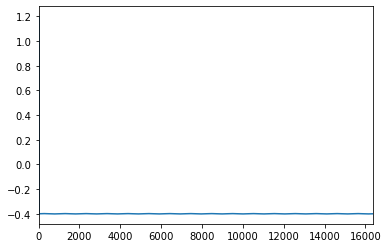

In [19]:
rr = _ecg_simulate_ecgsynth()
pd.Series(rr).plot()